# Class Activation Map (CAM)

In [178]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [179]:
# Keras Imports
import random
from tensorflow.keras import models
from tensorflow.keras.models import Model


import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.utils import load_img, img_to_array
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D
# Other imports
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import load_model

In [180]:
# load model
model = load_model("./inception_resnet_malaria.h5")

In [181]:

# summarize model.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 132, 132, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 65, 65, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 65, 65, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

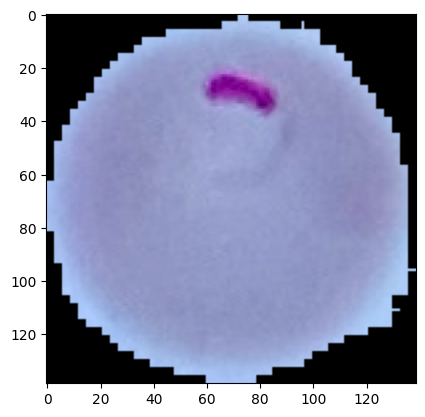

In [182]:
img = cv2.imread('./second_test.png')

plt.imshow(img)
plt.show()


1/1 [==============================] - 6s 6s/step


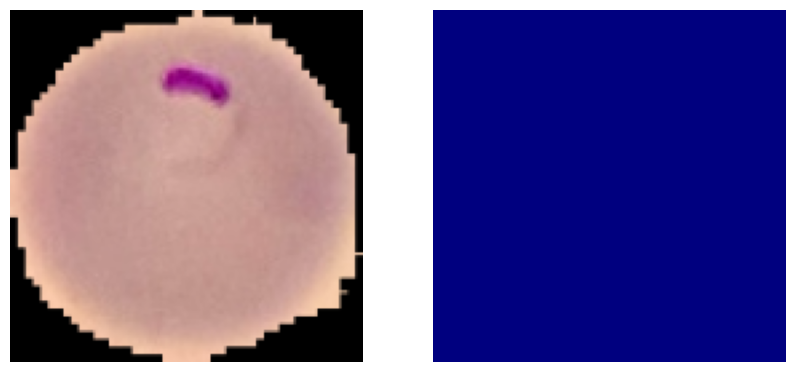

In [183]:
# BGR2RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Resizing it to (64,64,3)
img = cv2.resize(img,(132,132))

#Expand dims in axis = 0
img = np.expand_dims(img, axis=0)

# Generate prediction
pred = model.predict(img)

# Generate prediction class
pred_output = model.output[:, np.argmax(pred)]

# Feature map of 'f1' layer, which is the last convolution layer
last_conv_layer = model.get_layer('conv_7b')

# create a functional model
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

# New model's input shape
classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

# My model's classification layers (add layer names from last conv layer upto prediction layer)
classifier_layer_names = ["conv_7b_bn","conv_7b_ac",'global_average_pooling2d_1','dense_2','dense_3']


for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)

# Functional model creation
classifier_model = Model(classifier_input, x)

# Compute gradients
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1,2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

#Calculate heat map
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0)

    
heatmap = np.uint8(255*heatmap)


# apply jet color map
#heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.resize(heatmap,(132,132))
heatmap = heatmap.reshape((132,132))


plt.figure(figsize = [10,10])
plt.subplot(1,2,1)
plt.imshow(img.reshape(132,132,3))
plt.axis("off");

plt.subplot(1,2,2)
plt.imshow(heatmap,cmap = 'jet')
plt.axis("off");


#  NOT GENERATING PROPER HEATMAP
# WORK NEEDS TO BE DONE